In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [5]:
import os
os.chdir(os.path.join(os.getcwd().split('notebooks')[0], 'src'))

import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
import datetime
import time

from IPython import display

# Load and prepare the dataset

We'll use MNIST dataset to train the generator and the discriminator.

In [6]:
# load data from tf.keras.datasets
(train_images, train_labels), _ = tf.keras.datasets.mnist.load_data()

# add a channel dimension
train_images = train_images[:, :, :, np.newaxis]

# normalize to [-1, 1]
train_images = train_images / 255 - 0.5

In TensorFlow 2, use tf.data.Dataset object as the pipeline

In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# batch and shuffle
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)  # from NumPy array
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Create the models

## High-level (`tf.keras.Sequential`)

The generator generates **an image** from **a random seed**. It uses `tf.keras.layers.Conv2DTranspose` layers to upsample.

In [9]:
def make_generator_model():
    model = tf.keras.Sequential([
        
        # (100,) -> (7*7*256,)
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        # (7*7*256,) -> (7, 7, 256)
        layers.Reshape((7, 7, 256)),
        
        # (7, 7, 256 ) -> (7, 7, 128)
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        # (7, 7, 128) -> (14, 14, 64)
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        # (14, 14, 64) -> (28, 28, 1)
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        
    ])
    
    return model

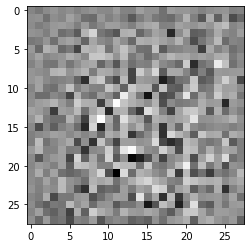

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

The discriminator is a CNN-based image **classifier**.

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        
        # (28, 28, 1) -> (14, 14, 64)
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        
        # (14, 14, 64) -> (7, 7, 128)
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        
        # (7, 7, 128) -> (1,)
        layers.Flatten(),
        layers.Dense(1),
    ])
    
    return model

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00223909]], shape=(1, 1), dtype=float32)


# Define loss and optimizers

## Loss

Discriminator loss quantifies how well the discriminator is able to distinguish real images from fakes. It compares:
- the discriminator's **predictions on real images** to an array of **1s**.
- the discriminator's **predictions on fake images** to an array of **0s**.


Generator loss quantifies how well it was able to trick the discriminator. If the generator is performing well, the discriminator will classify the fake images as real (or 1). Here we compare the discriminator's **predictions on the fake images** to an array of **1s**.

In [ ]:
# Binary cross-entropy loss as the base loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Optimizer

The discriminator and the generator optimizers are different since we will train two networks separately.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Metrics

We create custom metrics to keep track of the loss and write them to TensorBoard

In [ ]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/dcgan/' + current_time + '/train'
summary_writer = tf.summary.create_file_writer(log_dir)

gen_metric = tf.keras.metrics.Mean('gen_loss', dtype=tf.float32)
dis_metric = tf.keras.metrics.Mean('dis_loss', dtype=tf.float32)

# Training

## Training loop

Decorate the function to train one batch with `@tf.function` to run it in graph.

In [ ]:
@tf.function
def train_one_batch(images):
    
    # Create some random noise.
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        
        # Output of the generator
        generated_images = generator(noise, training=True)
        
        # Output of the discriminator
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # Loss computation
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(real_output, fake_output)
        
        # Metric recording
        gen_metric(gen_loss)
        dis_metric(dis_loss)
        
    # Gradients
    gen_grad = gen_tape.gradient(gen_loss, generator.trainable_variables)
    dis_grad = dis_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    # Apply gradients
    generator_optimizer.apply_gradients(zip(gen_grad, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(dis_grad, discriminator.trainable_variables))

In [ ]:
# Main training function.
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        # Train one step.
        for image_batch in dataset:
            train_one_batch(image_batch)
        
        # Write metrics to TensorBoard.
        with summary_writer.as_default():
            tf.summary.scalar('gen_loss', gen_metric.result(), step=epoch)
            tf.summary.scalar('dis_loss', dis_metric.result(), step=epoch)
        gen_metric.reset_states()
        dis_metric.reset_states()
        
        # Produce images for the GIF
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, test_seed)
        
#         # Save the model every 15 epochs.
#         if (epoch + 1) % 15 == 0:
#             pass
        
        print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, test_seed)

## Misc functions

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    """Generate predictions and save as image"""
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'../data/final_data/dcgan/image_at_epoch_{epoch:04d}.png')
    plt.show()

## Training

In [ ]:
EPOCHS = 50
noise_dim = 100
n_examples_to_generate = 16

# reuse the same seed overtime so it's easier to visualize progress
test_seed = tf.random.normal([n_examples_to_generate, noise_dim])

In [ ]:
train(train_dataset, EPOCHS)

# Create a GIF

In [ ]:
# Display a single image using the epoch number
def display_image(epoch):
    return PIL.Image.open(f'../data/final_data/dcgan/image_at_epoch_{epoch:04d}.png')

In [ ]:
display_image(132)

In [ ]:
anim_file = '../data/final_data/dcgan/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('../data/final_data/dcgan/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
#         if round(frame) > round(last):
#             last = frame
#         else:
#             continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)